**Table of Content:**
* [Get Data](#1)
* [Exploratory Data Analysis](#2)
* [Missing Data](#3)
* [Prepare the Data](#4)
* [Feature Engineering](#5)
* [Pipelines](#6)
* [Modeling](#7)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import os

<a id="1"></a>
## Get Data

In [2]:
df_train = pd.read_csv('./train.csv', index_col=0)
df_test = pd.read_csv('./test.csv', index_col=0)

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
X = df_train.copy()
y = X[['SalePrice']]

<a id="2"></a>
## Exploratory Data Analysis
### Univariate Analysis

In [5]:
# numerical columns
num_col = X.select_dtypes(exclude=['object'])

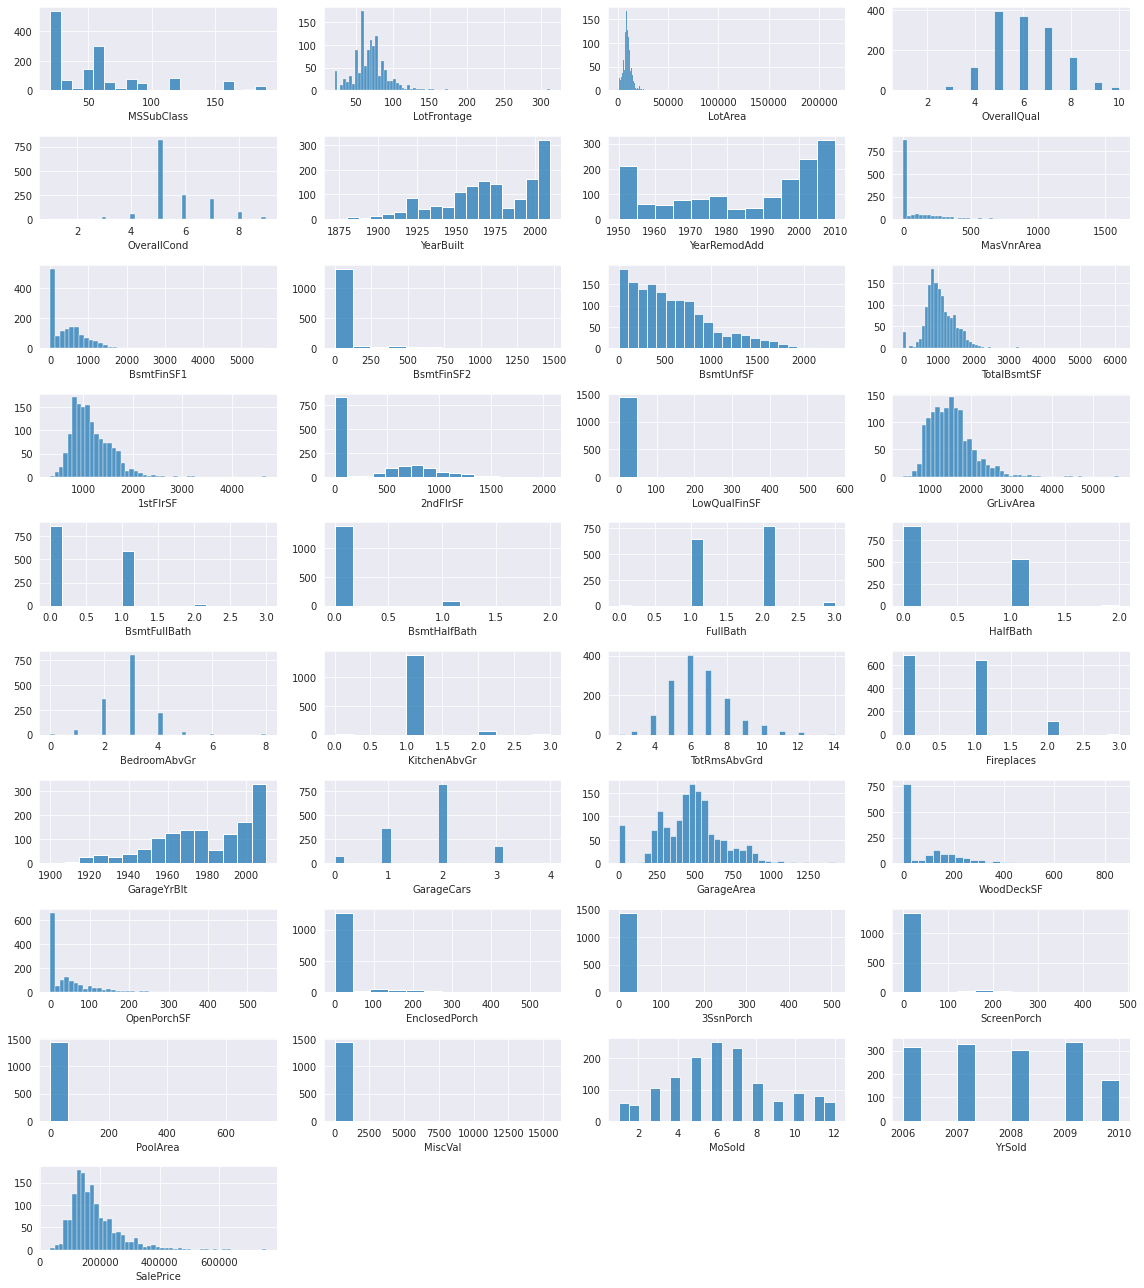

In [6]:
plt.figure(figsize=(16,18))

for i in range(len(num_col.columns)):
    plt.subplot(10, 4, i+1)
    sns.histplot(num_col.iloc[:, i].dropna())
    plt.ylabel("")
    
plt.tight_layout()
plt.show()

Many of the variables show strong skewness.

Columns 'OverallQual', 'OverallCond' look like they are of categorical type.

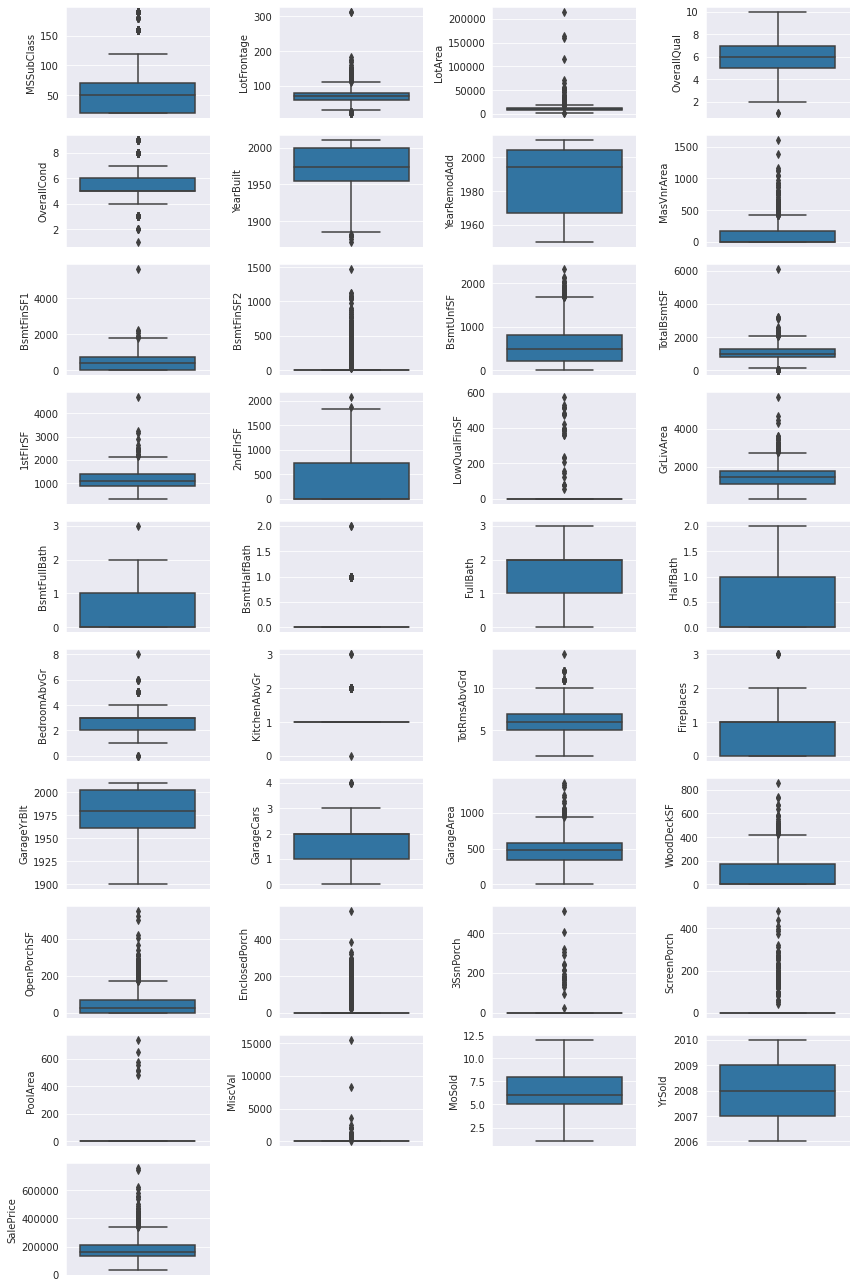

In [7]:
plt.figure(figsize=(12,18))

for i in range(len(num_col.columns)):
    plt.subplot(10,4,i+1)
    sns.boxplot(y=num_col.iloc[:, i])
    
plt.tight_layout()
plt.show()

In [8]:
skew_features = X.select_dtypes(exclude=['object']).skew().sort_values(ascending=False)
skew_features = pd.DataFrame({'Skew' : skew_features})
skew_features.style.background_gradient('rocket')

,Skew
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872


High skewness of variables will be normalized in feature engineering.

In [9]:
# categorical columns
cat_col = X.select_dtypes(include=['object'])

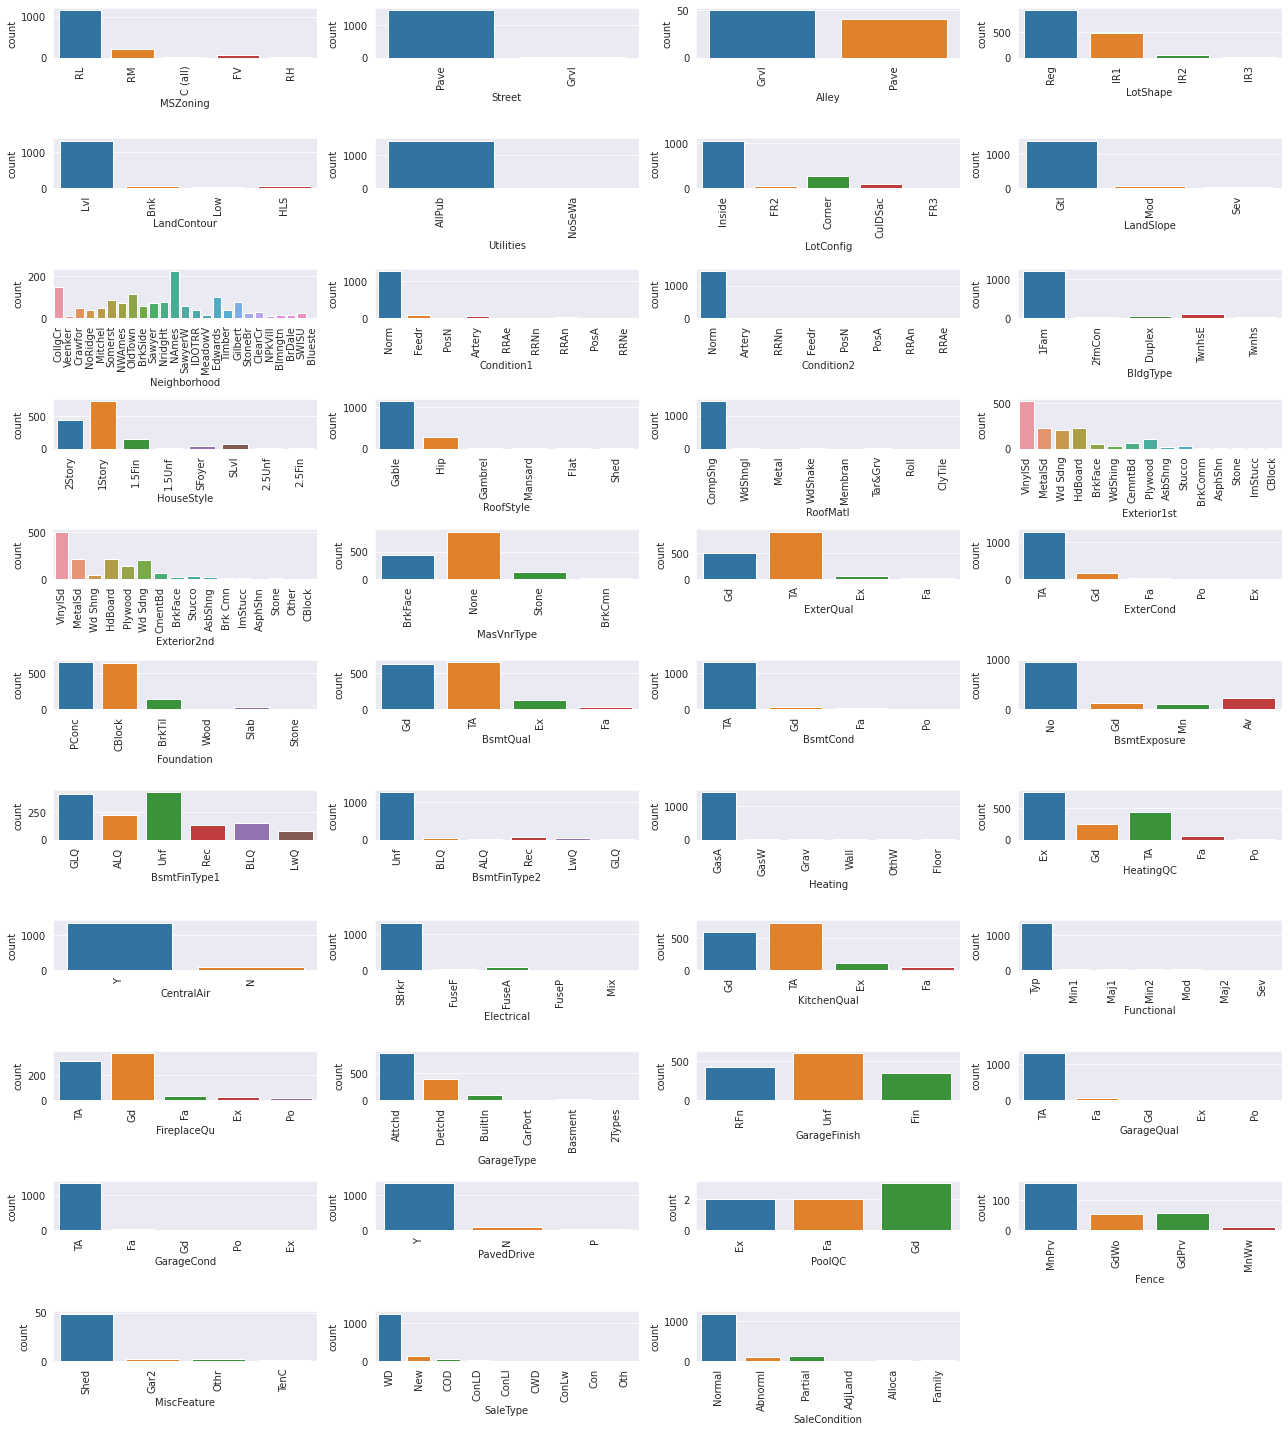

In [10]:
plt.figure(figsize=(18,20))
for i in range(len(cat_col.columns)):
    plt.subplot(11,4,i+1)
    sns.countplot(x=cat_col.iloc[:, i], data=cat_col.dropna())
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Bivariate Analysis
#### Correlation between Numerical Variables and SalePrice


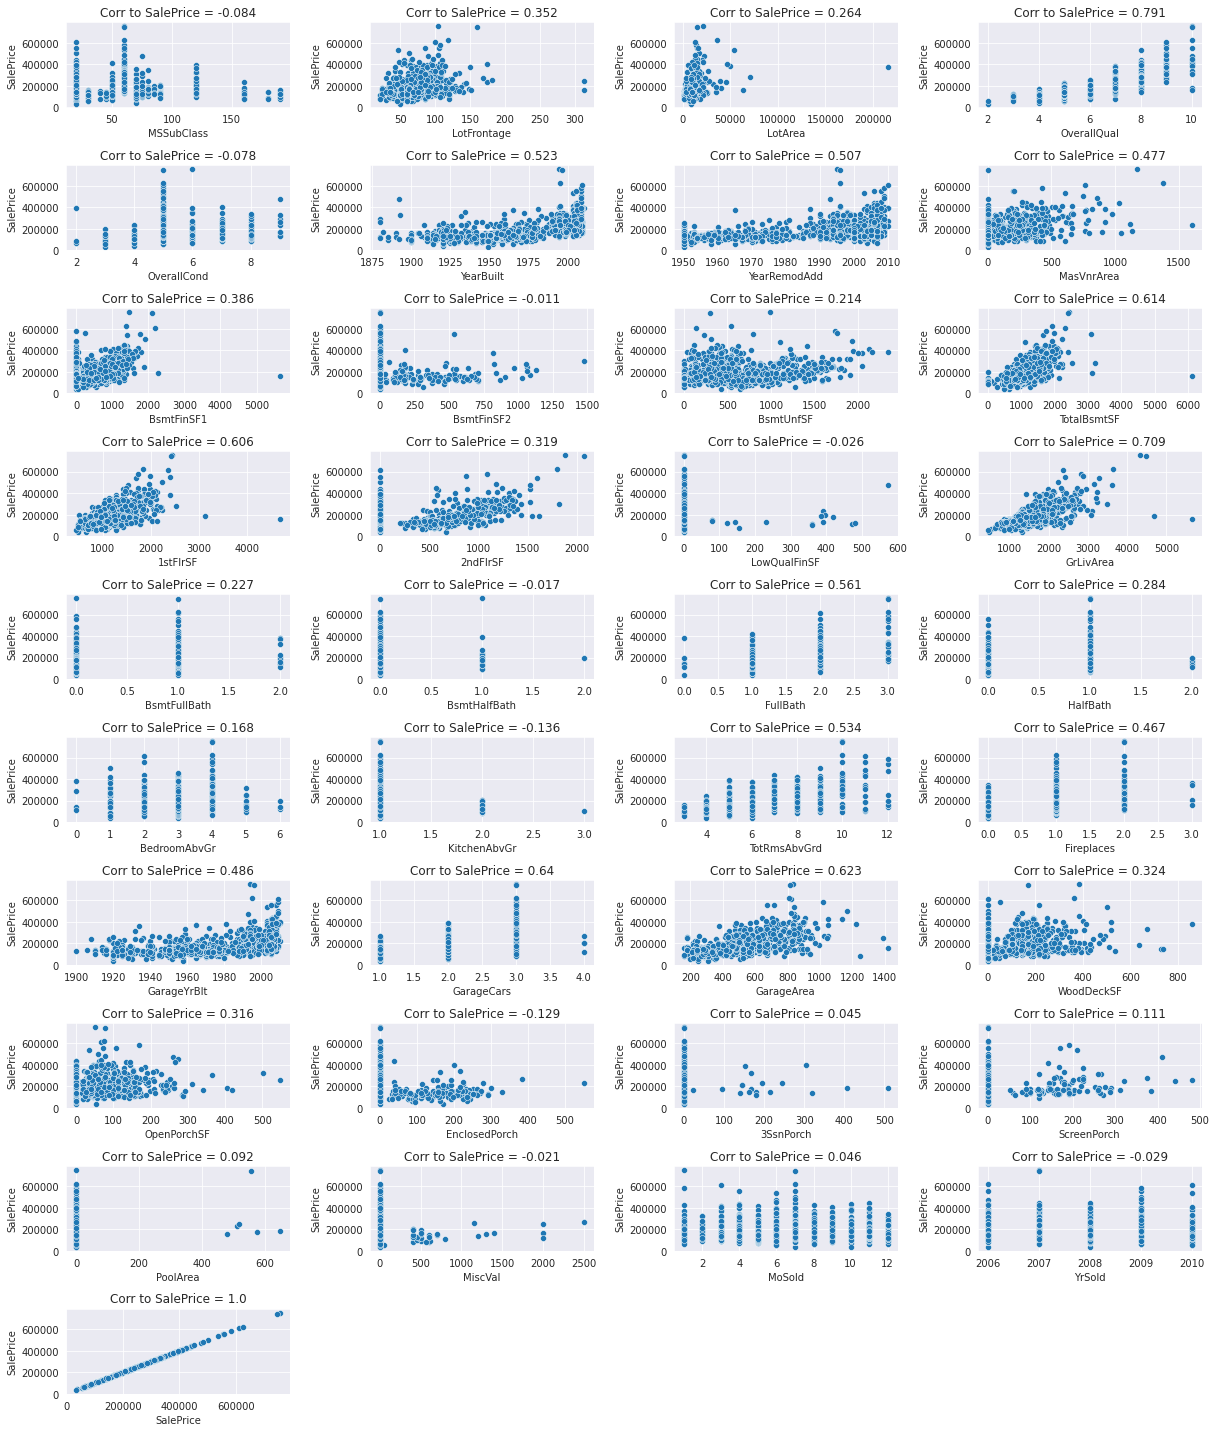

In [11]:
correlation = num_col.corr()
corr_price = correlation[['SalePrice']]

plt.figure(figsize=(17,20))
for i in range(len(num_col.columns)):
    plt.subplot(10,4,i+1)
    sns.scatterplot(x=num_col.iloc[:, i], y='SalePrice', data=num_col.dropna())
    plt.title('Corr to SalePrice = {}'.format(np.around(corr_price.iloc[i, 0], decimals=3)))
plt.tight_layout()
plt.show()


A few outliers:
- LotFrontage( >200)
- LotArea(>100000)
- BsmtFinSF1 (>4000)
- TotalBsmtSF (>5000)
- 1stFlrSF (>4000)
- GrLivArea (>4000 and SalePrice <300000)
- LowQualFinSF (>550)

### Correlation Between Variables

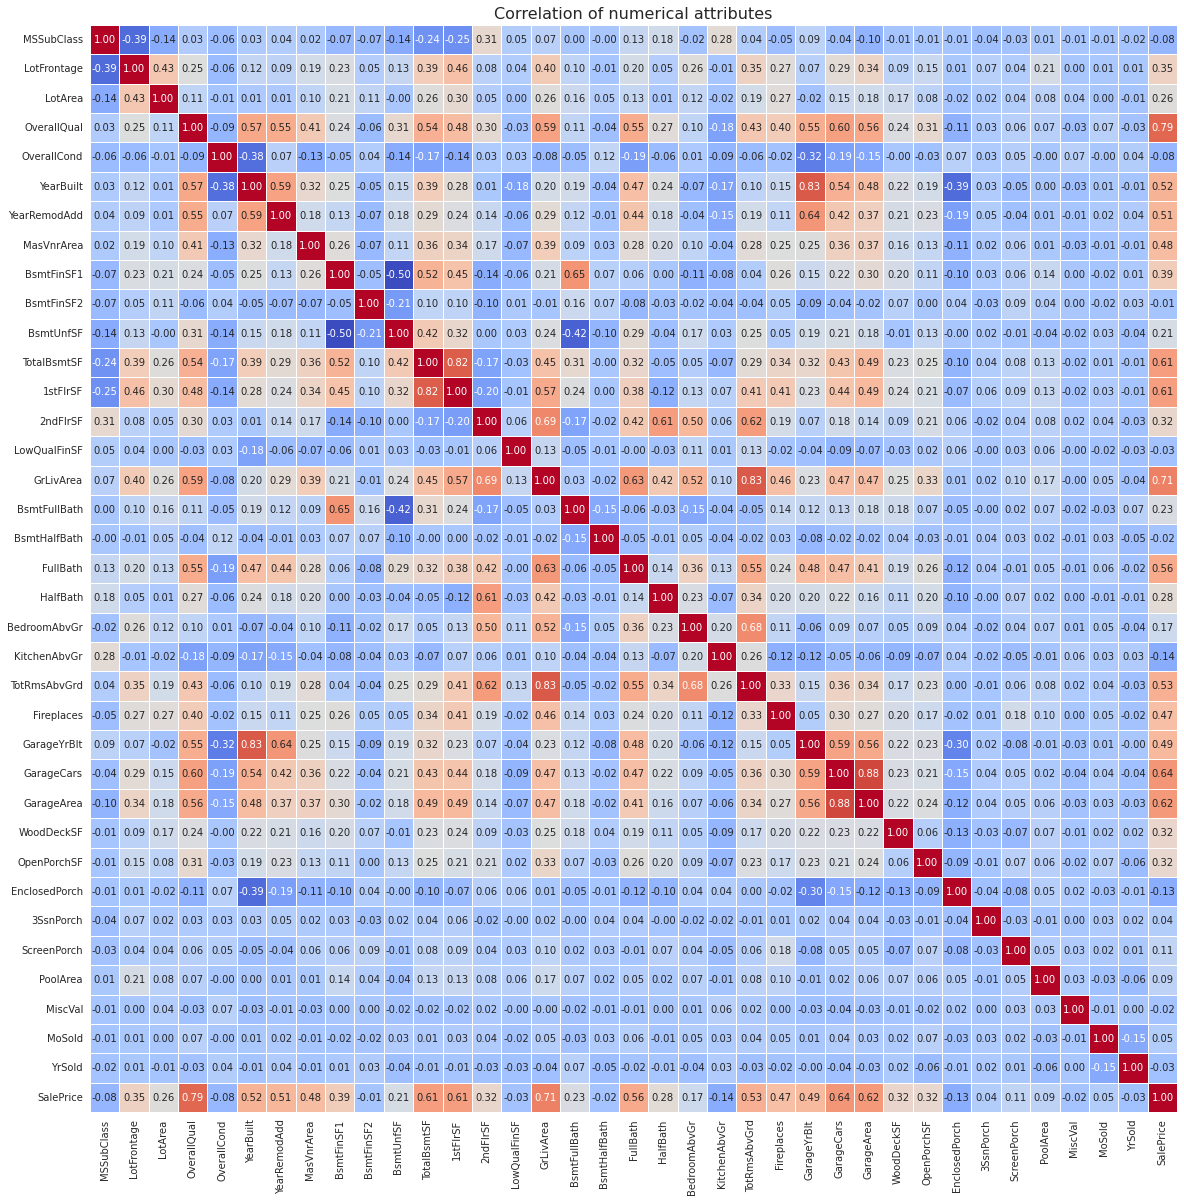

In [12]:
plt.figure(figsize=(20,20))
correlation = num_col.corr()
sns.heatmap(correlation, linewidth=1, cmap='coolwarm', annot=True, fmt='.2f', cbar=False, square=True)
plt.title("Correlation of numerical attributes", size=16)
plt.show()

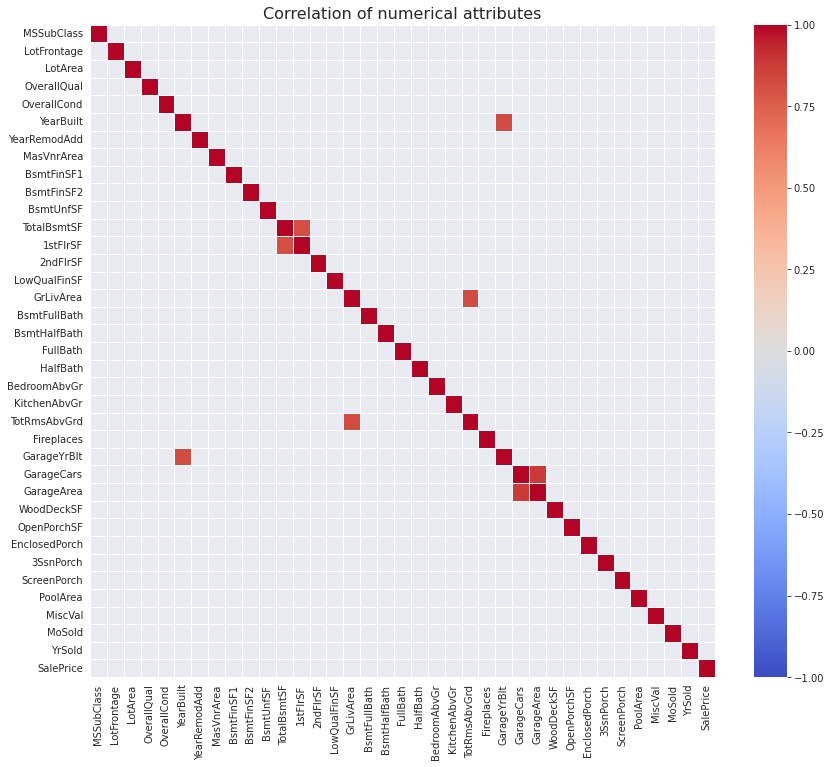

In [13]:
plt.figure(figsize=(14,12))
correlation = num_col.corr()
sns.heatmap(correlation, mask=correlation <0.8, linewidth=0.5, cmap='coolwarm', vmin=-1)
plt.title("Correlation of numerical attributes", size=16)
plt.show()

Highly Correlated variables:
- GarageYrBlt and YearBuilt
- TotRmsAbvGrd and GrLivArea
- 1stFlrSF and TotalBsmtSF
- GarageArea and GarageCars

Highly correlated variables will be dropped in feature engineering to avoid multicollinearity.

<a id="3"></a>
## Missing Data

In [14]:
def missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    total_missing = missing[missing != 0]
    percent_missing = np.around(((missing / len(df) * 100)[(missing / len(df) * 100) != 0]), decimals=2)
    return pd.concat([total_missing, percent_missing], axis=1, keys = ['Total', 'Percent'])

missing_data(X).style.background_gradient('rocket')

,Total,Percent
PoolQC,1453,99.520000
MiscFeature,1406,96.300000
Alley,1369,93.770000
Fence,1179,80.750000
FireplaceQu,690,47.260000
LotFrontage,259,17.740000
GarageYrBlt,81,5.550000
GarageCond,81,5.550000
GarageType,81,5.550000
GarageFinish,81,5.550000


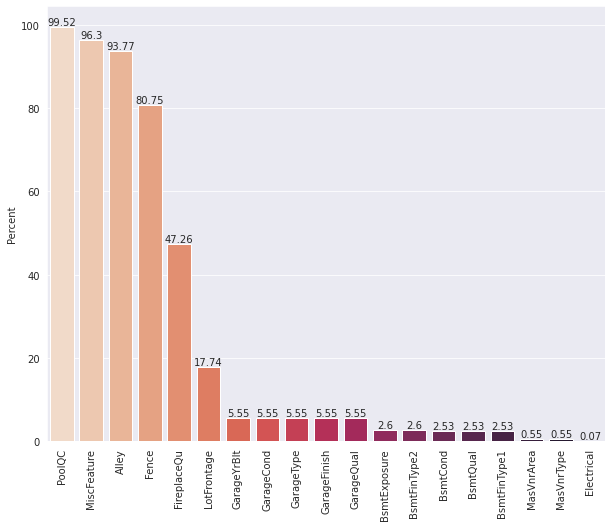

In [15]:
missing = missing_data(X)
plt.figure(figsize=(10,8))
ax = sns.barplot(x=missing.index, y='Percent', data=missing, palette='rocket_r')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

Columns 'PoolQC', 'MiscFeature' and 'Alley' has too many missing values. They will be dropped in feature engineering.

<a id="4"></a>
## Prepare the Data
### Drop outliers

In [16]:
X = X.drop(X[X['LotFrontage'] > 200].index)
X = X.drop(X[X['LotArea'] > 100000].index)
X = X.drop(X[X['BsmtFinSF1'] > 4000].index)
X = X.drop(X[X['TotalBsmtSF'] > 5000].index)
X = X.drop(X[(X['GrLivArea'] > 4000) & (X['SalePrice'] < 300000)].index)
X = X.drop(X[X['LowQualFinSF'] > 550].index)
X = X.drop(X[X['1stFlrSF'] > 4000].index)

In [17]:
from sklearn.model_selection import train_test_split

y = X.SalePrice.copy()
X.drop(['SalePrice'], axis=1, inplace=True)

X_test = df_test.copy()

# Spliting the data into training and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
print(f"Shape of X_train {X_train.shape}")
print(f"Shape of X_valid {X_valid.shape}")

Shape of X_train (1161, 79)
Shape of X_valid (291, 79)


### Feature Selection

In [18]:
col_corr_drop = {'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars'}
col_missing_drop = {'PoolQC', 'MiscFeature', 'Alley'}

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        
        X_copy = X.copy()
        # Features with multicollinearity
        X_copy.drop(col_corr_drop, axis=1, inplace=True)
        
        # Features with to many missing values
        X_copy.drop(col_missing_drop, axis=1, inplace=True)
        return X_copy

In [20]:
drop_features = DropFeatures()
X_train = drop_features.fit_transform(X_train, y)
X_valid = drop_features.transform(X_valid)
X_test = drop_features.transform(X_test)

## <a id="5"></a>
## Feature Engineering
### Numerical Columns

In [21]:
num_col_transform = list(set(X_train.select_dtypes(exclude='object').columns) - {'OverallQual', 'OverallCond'})

In [22]:
class CustomImputer(BaseEstimator, TransformerMixin):

    def __init__(self, imputer, strategy, fill_value=0):
        
        self.imputer = imputer
        self.strategy = strategy
        self.fill_value = fill_value

    def fit(self, X, y=None):
        
        self.imputer = self.imputer(strategy=self.strategy, fill_value = self.fill_value)
        self.imputer.fit(X, y)
        return self

    def transform(self, X):
        
        X_imp_tran = self.imputer.transform(X)
        X_imputer = pd.DataFrame(X_imp_tran, index=X.index, columns=X.columns)
        return X_imputer

In [23]:
class AddAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_attributes=True):
        
        self.add_attributes = add_attributes
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        
        if self.add_attributes:
            total_lot = X['LotFrontage'] + X['LotArea']
            total_bath = X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath'])
            total_sf = X['TotalBsmtSF'] + X['GrLivArea']
            new_features = pd.DataFrame(np.c_[total_lot, total_bath, total_sf], dtype='float64', columns=['TotalBath', 'TotalLot', 'TotalSF'], index=X.index)
            X_copy = pd.concat([X, new_features], axis=1)
            return X_copy
        else:
            return X

In [24]:
class DropCorrFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, corr_threshold=0.8):
        
        self.corr_threshold = corr_threshold
    
    def fit(self, X, y=None):
        
        num_col_corr = X.select_dtypes(exclude='object').columns  
        X_corr = (X[num_col_corr].corr() >= self.corr_threshold)
        col_corr = set()
        for i in range(X_corr.shape[0]):
            for j in range(X_corr.shape[1]):
                X_corr.iloc[j,j] = False
                if X_corr.iloc[i,j] == True:
                    col_corr.add(X_corr.columns[j])
        self.col_addcorr_drop =  list(col_corr - {'TotalLot', 'TotalBath', 'TotalSF'})           
        return self
    
    def transform(self, X):
        
        X_copy = X.copy()
        X_copy.drop(self.col_addcorr_drop, axis=1, inplace=True)
        return X_copy

In [25]:
from scipy.stats import skew

class SkewedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=0.8):
        
        self.skew_threshold = skew_threshold
    
    def fit(self, X, y=None):

        skew_features = X.select_dtypes(exclude='object').apply(lambda x: skew(x))
        self.skew_features_high = skew_features[abs(skew_features) > self.skew_threshold].index
        return self
    
    def transform(self, X):
        
        X[self.skew_features_high] = np.log1p(X[self.skew_features_high])
        return X

### Categorical Columns

In [26]:
cat_col_transform = X_train.select_dtypes(include='object')

cat_ordinal = list({'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
                    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                    'Fence', 'PoolQC'} - col_corr_drop - col_missing_drop)

missing_data(X_train[cat_ordinal])

,Total,Percent
Fence,942,81.14
FireplaceQu,533,45.91
GarageCond,64,5.51
GarageQual,64,5.51
GarageFinish,64,5.51
BsmtExposure,32,2.76
BsmtFinType2,32,2.76
BsmtCond,31,2.67
BsmtFinType1,31,2.67
BsmtQual,31,2.67


In [27]:
cat_ordinal_num = ['OverallQual', 'OverallCond']

missing_data(X_train[cat_ordinal_num])

,Total,Percent


In [28]:
cat_bin = list({'Street', 'Alley', 'CentralAir'} - col_corr_drop - col_missing_drop)

missing_data(X_train[cat_bin])

,Total,Percent


In [29]:
cat_nominal = list(set(cat_col_transform) - set(cat_ordinal) - set(cat_bin) - set(cat_ordinal_num))

missing_data(X_train[cat_nominal])

,Total,Percent
GarageType,64,5.51
MasVnrType,6,0.52
Electrical,1,0.09


In [30]:
# Encoding Categorical Columns

Utilities_map = {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0}
GarageQual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
Fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}
GarageFinish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
KitchenQual_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
GarageCond_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
HeatingQC_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
ExterQual_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
BsmtCond_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
LandSlope_map = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
ExterCond_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
BsmtExposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
PavedDrive_map = {'Y': 2, 'P': 1, 'N': 0}
BsmtQual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
LotShape_map = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
BsmtFinType2_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
BsmtFinType1_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
FireplaceQu_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

In [31]:
ordinal_mapping = [{'col': col, 'mapping': globals()[col + '_map']} 
                    for col in cat_ordinal]

In [32]:
CentralAir_map = {'Y': 1, 'N': 0}
Street_map = {'Pave': 1, 'Grvl': 0}

In [33]:
binary_mapping = [{'col': col, 'mapping': globals()[col + '_map']}
                     for col in cat_bin]

## <a id="6"></a>
## Pipelines

In [34]:
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Preprocessing for numerical data
num_transformer = Pipeline(steps=[
    ('num_imputer', CustomImputer(SimpleImputer, strategy='median')),
    ('adder', AddAttributes()),
    ('drop_corr', DropCorrFeatures()),
    ('skew_func', SkewedFeatures()),
    ('std_scaler', StandardScaler())
])

# Preprocessing for categorial data
cat_transformer_ordinal = Pipeline(steps=[
    ('cat_ordinal_imputer', CustomImputer(SimpleImputer, strategy='constant', fill_value='NA')),
    ('ordinal_encoder', ce.OrdinalEncoder(mapping = ordinal_mapping))
])
                                   
cat_transformer_ordinal_num = Pipeline(steps=[
    ('cat_ordinal_imputer_num', CustomImputer(SimpleImputer, strategy='most_frequent'))
])

cat_transformer_bin = Pipeline(steps=[
    ('cat_bin_imputer', CustomImputer(SimpleImputer, strategy='most_frequent')),
    ('binary_encoder', ce.OrdinalEncoder(mapping = binary_mapping))
])

cat_transformer_nominal = Pipeline(steps=[
    ('cat_nominal_imputer', CustomImputer(SimpleImputer, strategy='most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col_transform),
        ('cat_ordinal', cat_transformer_ordinal, cat_ordinal),
        ('cat_ordinal_num', cat_transformer_ordinal_num, cat_ordinal_num),
        ('cat_bin', cat_transformer_bin, cat_bin),
        ('cat_nominal', cat_transformer_nominal, cat_nominal)
    ], remainder='passthrough')

  
X_train_prepared = preprocessor.fit_transform(X_train)
X_valid_prepared = preprocessor.transform(X_valid)
X_test_prepared = preprocessor.transform(X_test)

## <a id="7"></a>
## Modeling

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

XGB = XGBRegressor()

param_grid = {
    'learning_rate' : [0.01, 0.1, 0.3, 0.5],
    'n_estimators' : [10, 50, 100, 200],
    'max_depth' : [3, 6, 9]
}

grid_search = GridSearchCV(XGB, param_grid, cv=5, scoring = 'neg_root_mean_squared_error')
       
grid_search.fit(X_train_prepared, y_train)
XGB_new = grid_search.best_estimator_

# Preprocessing of validation data
preds = XGB_new.predict(X_valid_prepared)

# Evaluate the model
print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 14522.15261222079


In [36]:
preds_test = XGB_new.predict(X_test_prepared)

In [37]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)